<hr style="border:2px solid #0281c9"> </hr>

<img align="left" alt="ESO Logo" src="http://archive.eso.org/i/esologo.png">  

<div align="center">
  <h1 style="color: #0281c9; font-weight: bold;">ESO Science Archive</h1> 
  <h2 style="color: #0281c9; font-weight: bold;">Jupyter Notebooks</h2>
</div>

<hr style="border:2px solid #0281c9"> </hr>

# **Raw Data: Query for by Source Name or Position**

This notebook demonstrates how to use the `astroquery.eso` module to search for and download HAWK-I near-infrared observations from the ESO archive, specifically targeting Sgr A*, the supermassive black hole at the center of the Milky Way. It guides users through querying both the main ESO archive table and instrument-specific tables, filtering results based on observation parameters, and retrieving raw, unprocessed data for further calibration and analysis, enabling direct access to ESO’s extensive collection of observational datasets.

<hr style="border:2px solid #0281c9"> </hr>

# **Importing and basic usage of astroquery.eso**

In [1]:
import astroquery # import astroquery
print(f"astroquery version: {astroquery.__version__}") # check the version of astroquery

astroquery version: 0.4.11.dev10245


In [2]:
from astroquery.eso import Eso # import the ESO module from astroquery

In [3]:
eso = Eso() # create an instance of the ESO class 

# **Performing a Small Cone Search Around Sgr A***

To perform a small cone search of **10 arcseconds** around the source **Sgr A**, we first need to resolve the source name to obtain its **Right Ascension (RA)** and **Declination (Dec)** coordinates. This can be done using an online name resolver such as the ``SkyCoord.from_name()`` method from astropy.coordinates, which allows us to resolve object names into precise RA/Dec coordinates using online astronomical databases. This gives (ICRS): 

```python
ra = 266.41681663
dec = -29.00782497
```

In coordinate values of degrees in the ICRS (International Celestial Reference System) frame.

In [4]:
from astropy.coordinates import SkyCoord # import the SkyCoord class from the astropy.coordinates module
import astropy.units as u # import the astropy.units module

In [5]:
target = "Sgr A*" # set the target to Sgr A*
coords = SkyCoord.from_name(target) # create a SkyCoord object from the name of the source 
radius = 3 *u.arcmin # set the radius of the search to 3 arcminutes

print(f"Coordinates of Sgr A*: {coords}") # print the coordinates of Sgr A*

Coordinates of Sgr A*: <SkyCoord (ICRS): (ra, dec) in deg
    (266.41681663, -29.00782497)>


In [6]:
eso.maxrec = 1000    # For this example we limit the number of records to 1000

## **Raw data cone search**

### **Instrument specific search**

The ``query_instrument()`` method allows you to query raw data tables that are specific to a particular ESO instrument. These tables contain metadata fields tailored to the selected instrument, which are not necessarily available in other instrument specific tables. This makes ``query_instrument()`` ideal when you’re working with a known instrument and need detailed, instrument-specific parameters.

With this in mind, before starting a query, we can inspect the available queryable columns using the `help=True` keyword in the `query_instrument()` method for any specific instrument. This is a useful first step to understand what metadata is available and how to structure your query (if additional constraints are needed). The output includes `column name`, `data type`, `unit`, and, where applicable, `xtype` information to indicate more specific column content. For example, a column with datatype char may represent a timestamp or a sky region, which is reflected in the xtype field (e.g., timestamp or adql:REGION).

In [33]:
eso.query_instrument("HAWKI", help=True)

INFO: 
Columns present in the table ist.HAWKI:
      column_name        datatype    xtype     unit 
------------------------ -------- ----------- ------
          access_estsize     long              kbyte
              access_url     char                   
            datalink_url     char                   
                date_obs     char                   
                     dec   double                deg
                 det_dit    float                  s
         det_ncorrs_name     char                   
                det_ndit      int                   
           dimm_fwhm_avg    float             arcsec
           dimm_fwhm_rms    float             arcsec
                  dp_cat     char                   
                   dp_id     char                   
                 dp_tech     char                   
                 dp_type     char                   
                 ecl_lat   double                deg
                 ecl_lon   double                deg

Now we know what columns we're going to retrieve in from query, we can use the cone search functionality available through `query_instrument()` by passing `cone_ra`, `cone_dec`, and `cone_radius` arguments...

In [32]:
table_raw = eso.query_instrument("HAWKI",
                            cone_ra=coords.ra.value, 
                            cone_dec=coords.dec.value, 
                            cone_radius=radius.to("deg").value) # query the ESO archive for HAWKI data

table_raw["object", "ra", "dec", "prog_id", "instrument", "dp_id"][:3] # print the first 3 rows of the table

/opt/anaconda3/envs/astroquery_eso/lib/python3.13/site-packages/pyvo/dal/query.py:341: DALOverflowWarning: Partial result set. Potential causes MAXREC, async storage space, etc.
  warn("Partial result set. Potential causes MAXREC, async storage space, etc.",


object,ra,dec,prog_id,instrument,dp_id
,deg,deg,,,
object,float64,float64,object,object,object
OBJECT,266.410333,-29.00929,091.B-0418(D),HAWKI,HAWKI.2013-06-07T01:48:48.326
Galactic Center Position 1,266.408009,-29.00978,091.B-0418(D),HAWKI,HAWKI.2013-06-07T02:03:33.592
Galactic Center Position 1,266.408009,-29.00978,091.B-0418(D),HAWKI,HAWKI.2013-06-07T02:05:08.806


At this point it may be useful to know some information about the columns in the table. We can print the column names and their descriptions as follows:


In [28]:
print("Column Descriptions:\n" + "-" * 25)
for colname in table_raw.colnames:
    desc = table_raw[colname].info.description
    desc_str = desc if desc is not None else "[no description]"
    print(f"{colname:>25}: {desc_str}")

Column Descriptions:
-------------------------
                   object: Identifier or name of the target observed. It is either the target designation (as given by the astronomer) for science exposures, or the exposure type for non-science frames (e.g. FLAT,LAMP). Originating from FITS keyword: OBJECT.
                       ra: Right Ascension of the pointing (FK5). Expressed in degrees. Originating from FITS keyword: RA.
                      dec: Declination of the pointing (FK5). Expressed in degrees. Originating from FITS keyword: DEC.
                    dp_id: Primary unique identifier for the ESO archive file.
                 date_obs: A string (varchar, not a datetime) representing the start time of the observing block (OB). It can be used to match (also using SQL wild cards) the string expressed as ISO 8601 compliant date-time format 'YYYY-MM-DDTHH:MM:SS' (accurate to the second), with a 'T' separating the date and time (e.g., 2000-01-01T00:00:00). Not being a datetime fie

### **Generic archive search**

The `query_main()` method allows you to query the **global raw data table**, which merges metadata across all ESO instruments into a unified structure. This method is particularly useful when:

- You do **not know** which instrument was used,
- You want to search across **multiple instruments** at once,
- Or you are performing a **broad, exploratory query** of the archive.

Unlike `query_instrument()`, which accesses instrument-specific tables with rich metadata, `query_main()` operates on a more general table that includes **only metadata columns common to all instruments** (e.g., `object`, `ra`, `dec`, `exptime`, `filter`, `dp_id`, etc.).

As with `query_instrument()`, you can inspect the available queryable columns in ``query_main`` using the `help=True` keyword. This allows you to understand which metadata fields are available in the main archive table, along with their data type, units, and `xtype` information (e.g., `timestamp`, `adql:REGION`), which helps in formulating queries correctly (note here we do not need to supply the instrument).

In [37]:
eso.query_main(help=True)

INFO: 
Columns present in the table dbo.raw:
    column_name     datatype    xtype     unit 
------------------- -------- ----------- ------
     access_estsize     long              kbyte
         access_url     char                   
       datalink_url     char                   
           date_obs     char                   
                dec   double                deg
            dec_pnt   double                deg
        det_chip1id     char                   
   det_chop_ncycles    short                   
            det_dit    float                  s
          det_expid    short                   
           det_ndit    short                   
             dp_cat     char                   
              dp_id     char                   
            dp_tech     char                   
            dp_type     char                   
            ecl_lat   double                deg
            ecl_lon   double                deg
          exp_start     char   timestamp   

Now we know what columns we're going to retrieve in from query, we can use the cone search functionality available through `query_main()` by passing `cone_ra`, `cone_dec`, and `cone_radius` arguments (same as before)...

In [35]:
table_raw = eso.query_main("HAWKI",
                        cone_ra=coords.ra.value, 
                        cone_dec=coords.dec.value, 
                        cone_radius=radius.to("deg").value) # query the ESO archive for HAWKI data

table_raw["object", "ra", "dec", "prog_id", "instrument", "dp_id"][:3] # print the first 3 rows of the table

object,ra,dec,prog_id,instrument,dp_id
,deg,deg,,,
object,float64,float64,object,object,object
GALACTIC CENTER POSITION 1,266.40800888,-29.00978,091.B-0418(D),HAWKI,HAWKI.2013-06-07T02:02:30.689
GALACTIC CENTER POSITION 1,266.40800888,-29.00978,091.B-0418(D),HAWKI,HAWKI.2013-06-07T02:24:42.652
GALACTIC CENTER POSITION 1,266.40800888,-29.00978,091.B-0418(D),HAWKI,HAWKI.2013-06-07T02:26:16.998


Again, at this point it may be useful to know some information about the columns in the table. We can print the column names and their descriptions as follows:


In [36]:
print("Column Descriptions:\n" + "-" * 25)
for colname in table_raw.colnames:
    desc = table_raw[colname].info.description
    desc_str = desc if desc is not None else "[no description]"
    print(f"{colname:>25}: {desc_str}")

Column Descriptions:
-------------------------
                   object: Target designation as given by the astronomer, though at times overwritten by the obeservatory, especially for CALIB observations. Compare with the similar field called "target".)
                       ra: Right Ascension FK5 J2000
                      dec: Declination FK5 J2000
                    dp_id: The main unique ESO archive file identifier
                 date_obs: The content of the DATE_OBS keyword exposed as a string and not a datetime field (ESO_DATEADD_SEC does not work on this column, use exp_start instead).
                  prog_id: ESO program run identification code
           access_estsize: Estimated size of the downloaded file in KBytes. It is only "estimated" as in general, FITS headers can be patched at download time, making the file size varying with time.)
               access_url: A URL that can be used to download the raw file; if the file is under proprietary period, only authenti

### 📊 **Visualizing Metadata Distributions**

The cell below creates a multi-panel figure showing the distribution of key metadata fields returned from the ESO archive query. For each column:

- **Numeric fields** (e.g., `exposure`, `tel_airm_start`) are shown as histograms.
- **Categorical fields** (e.g., `prog_id`, `filter_path`, `dp_type`) are shown as bar charts, with counts of each unique value.

This is useful to:
- Get an overview of your query results,
- Identify dominant filters, programs, or dataproduct types,
- Examine the range and spread of exposure times and other numeric parameters.

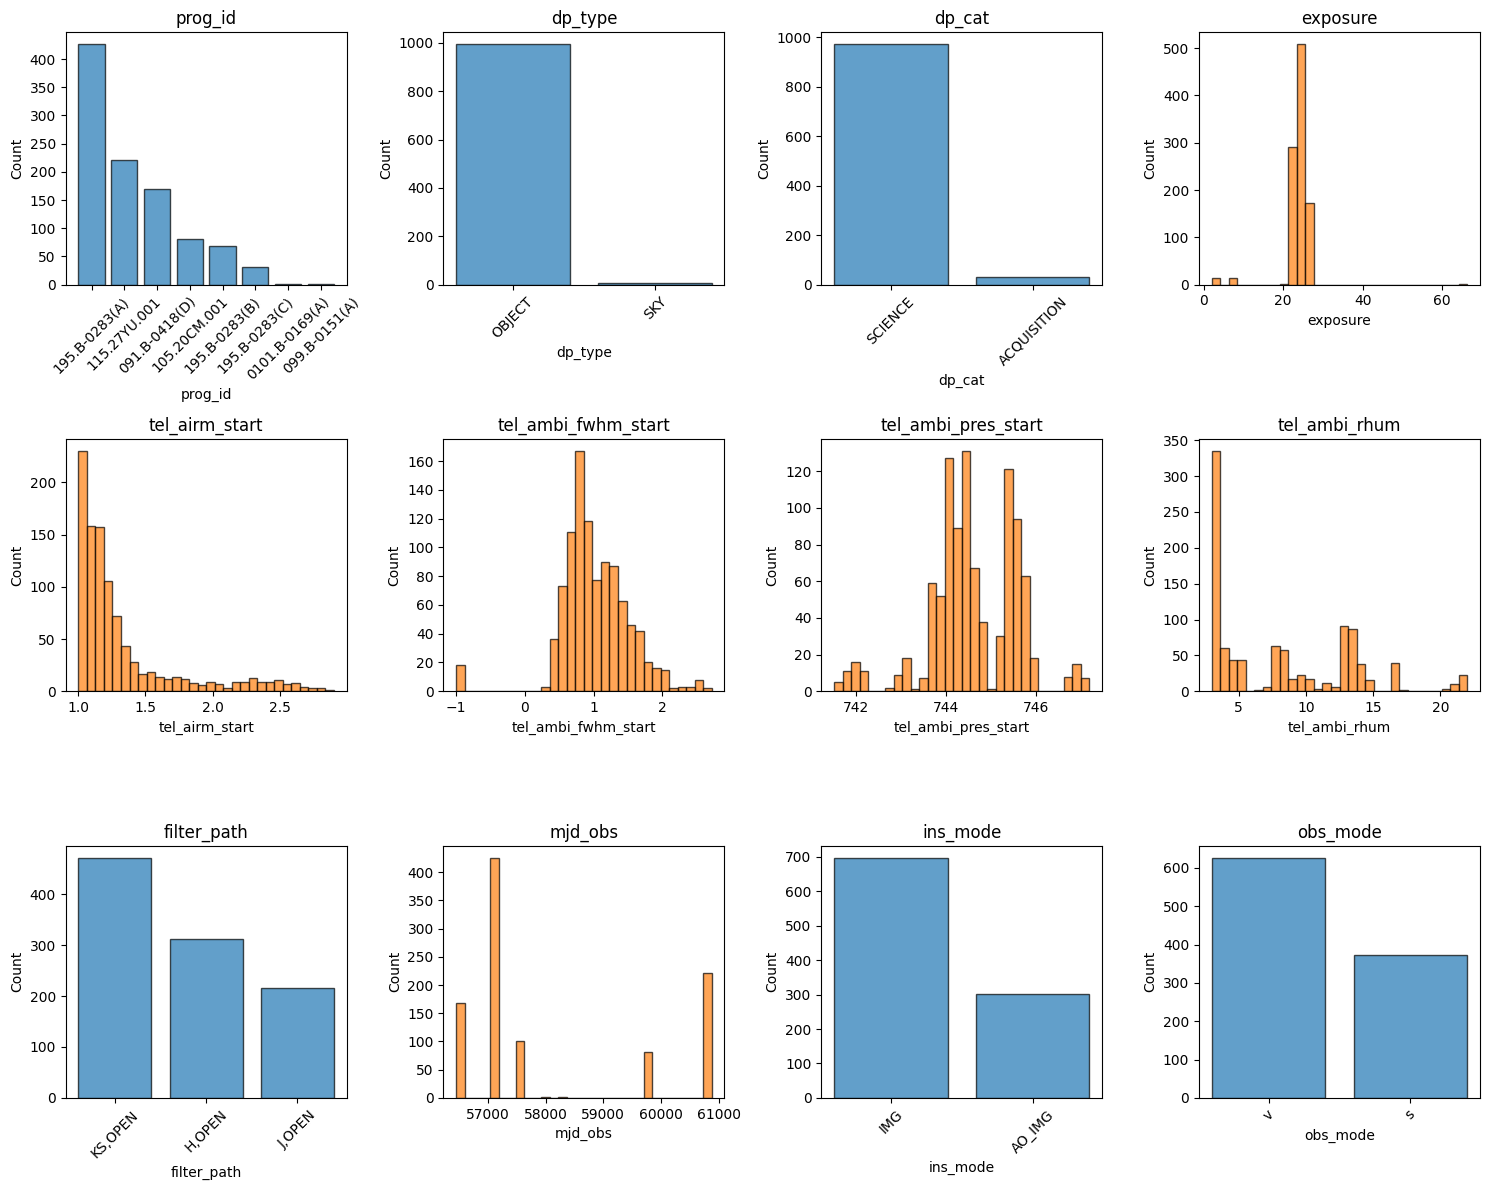

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Define columns to plot
columns = [
    "prog_id", "dp_type", "dp_cat", "exposure",
    "tel_airm_start", "tel_ambi_fwhm_start", "tel_ambi_pres_start", "tel_ambi_rhum", 
    "filter_path", "mjd_obs", "ins_mode", "obs_mode"
]
# Prepare plot grid
n = len(columns)
ncols = 4
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4 * nrows))
axes = axes.flatten()

# Loop over each column
for ax, col in zip(axes, columns):
    data = table_raw[col]
    
    # Remove masked or NaN values
    if np.ma.is_masked(data):
        data = data[~data.mask]
    data = data[~np.isnan(data)] if data.dtype.kind in 'f' else data  # remove NaNs from floats

    # Check if numeric or categorical
    if data.dtype.kind in 'biufc':  # numeric
        ax.hist(data, bins=30, color='C1', edgecolor='black', alpha=0.7)
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
    else:  # categorical
        counts = Counter(data)
        labels, values = zip(*counts.most_common())
        ax.bar(labels, values, color='C0', edgecolor='black', alpha=0.7)
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        ax.tick_params(axis='x', rotation=45)

    ax.set_title(col)

# Hide any unused subplots
for ax in axes[n:]:
    ax.axis('off')

plt.tight_layout()

# **Downloading datasets from the archive**

The returned table has an ``dp_id`` column. It can be used to retrieve the datasets with ``retrieve_data()``.

The file names, returned in ``data_files``, points to the decompressed datasets (without the .Z extension) that have been locally downloaded. 

The default location (in the ``astropy`` cache) of the decompressed datasets can be adjusted by providing a destination keyword in the call to ``retrieve_data()``. By default, if a requested dataset is already found, it is not downloaded again from the archive. To force the retrieval of data that are present in the destination directory, use ``continuation=True`` in the call to ``retrieve_data()``.

In [ ]:
# data_files = eso.retrieve_data(table_raw["dp_id"][0]) # download the first data product
# data_files = eso.retrieve_data(table['dp_id'][0], continuation=True) # force the download of all files even if present in the destination directory
# data_files = eso.retrieve_data(table['dp_id'][0], destination='./') # specify the destination directory for the download

INFO: Downloading datasets ... [astroquery.eso.core]
INFO: Downloading 1 files ... [astroquery.eso.core]
INFO: Downloading file 1/1 https://dataportal.eso.org/dataPortal/file/HARPS.2003-06-18T09:06:13.920 to /Users/abarnes/.astropy/cache/astroquery/Eso [astroquery.eso.core]
INFO: Found cached file /Users/abarnes/.astropy/cache/astroquery/Eso/HARPS.2003-06-18T09:06:13.920.fits [astroquery.eso.core]
INFO: Done! [astroquery.eso.core]


<hr style="border:2px solid #0281c9"> </hr>